In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [87]:
train = pd.read_csv('data/train_data.csv')
test = pd.read_csv('data/test_a.csv')

In [88]:
#特征存储类型为object类型
f1 = train.dtypes[train.dtypes=='object'].index
#连续性类型特征
f2 = train.dtypes[train.dtypes!='object'].index

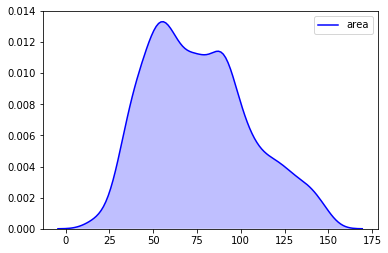

In [89]:
#测试集area分布
sns.kdeplot(test['area'], color="Blue", shade= True)

In [90]:
train = train[(train['area']<=175)&(train['area']>10)]
train = train[train['tradeMoney']<=20000]

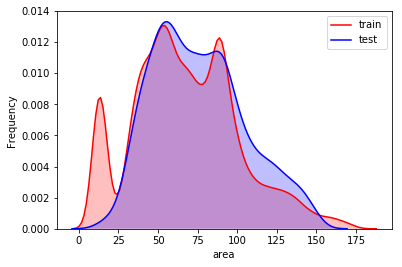

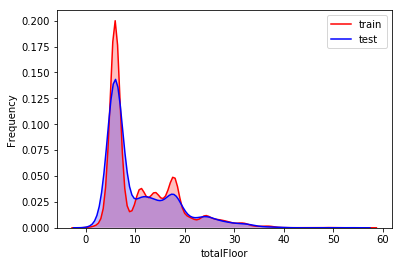

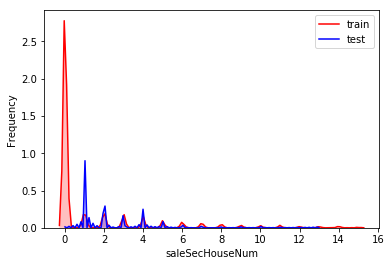

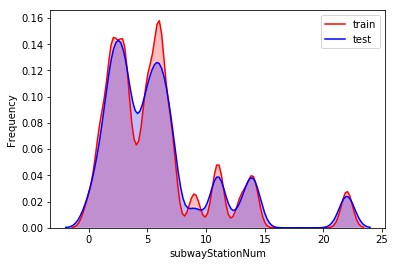

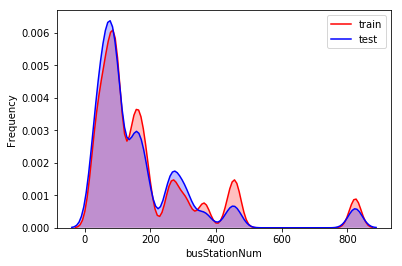

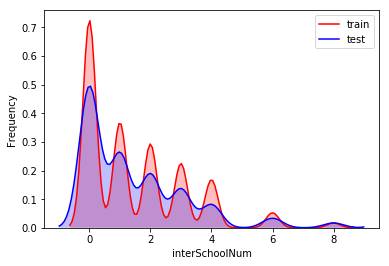

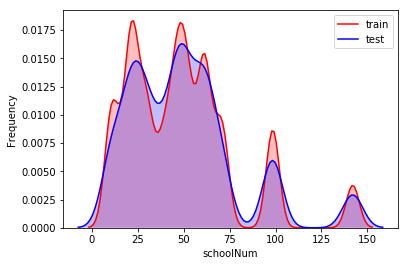

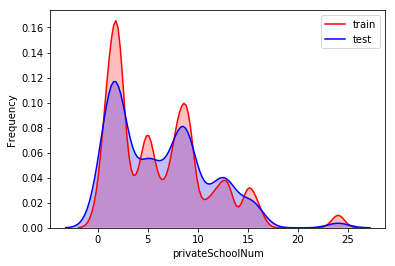

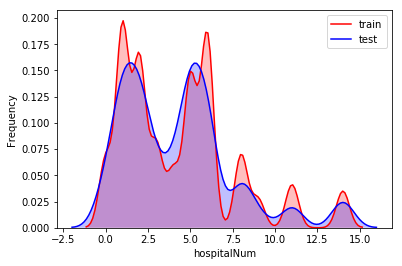

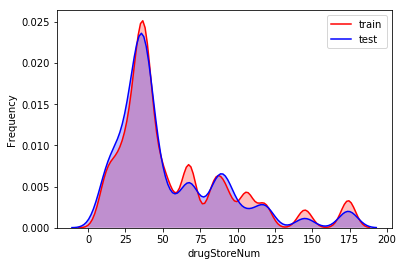

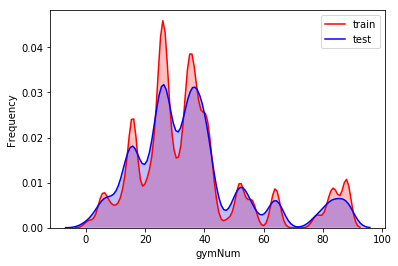

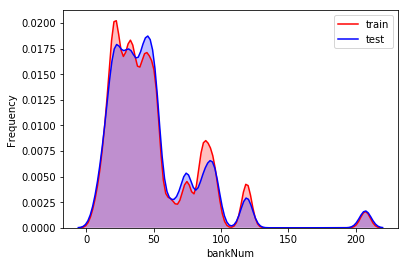

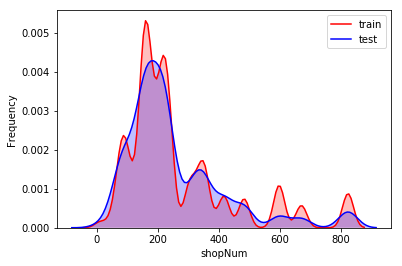

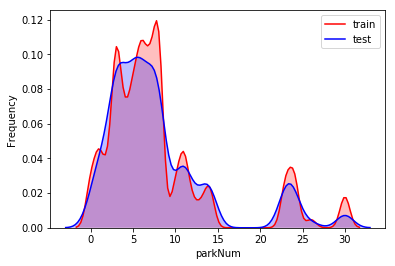

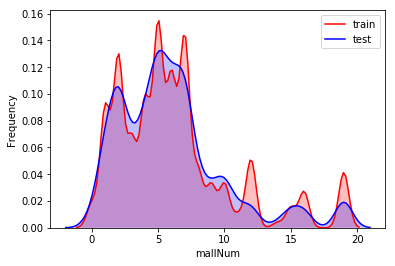

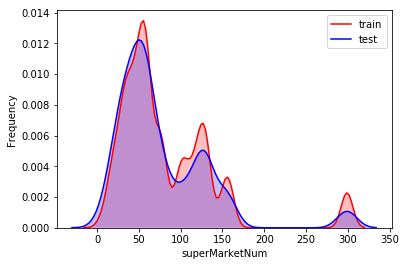

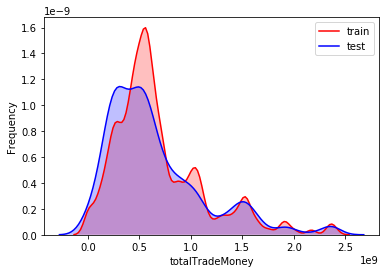

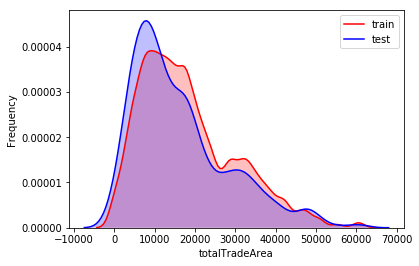

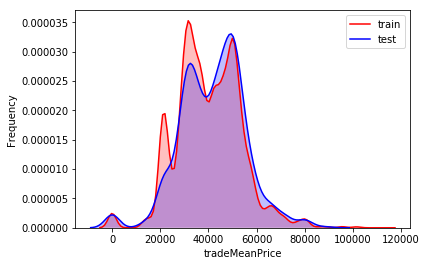

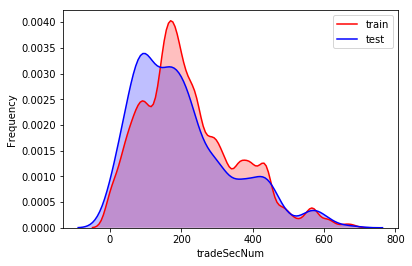

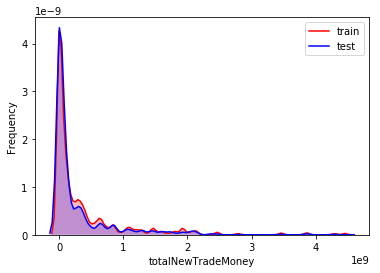

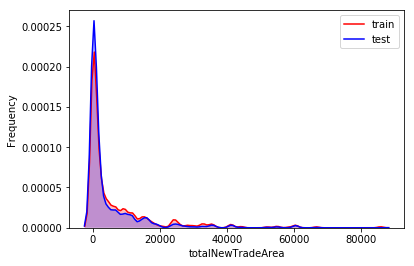

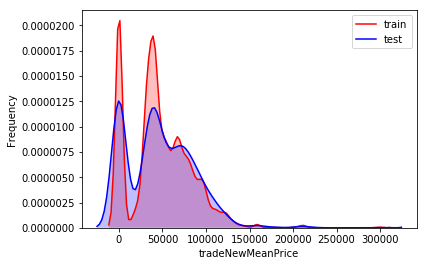

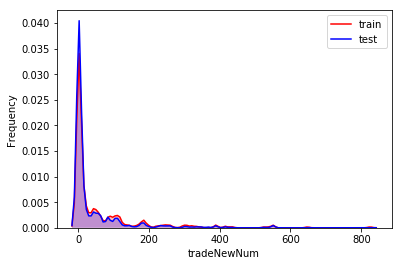

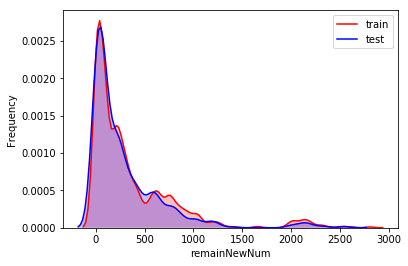

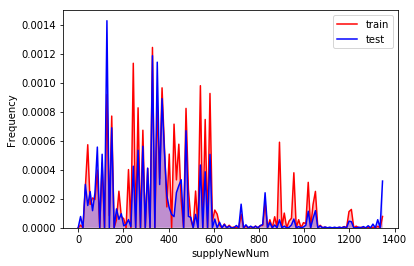

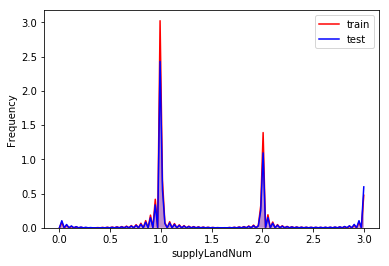

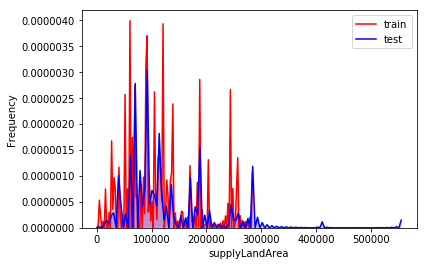

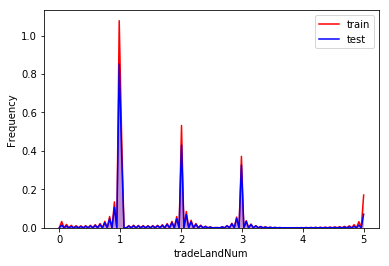

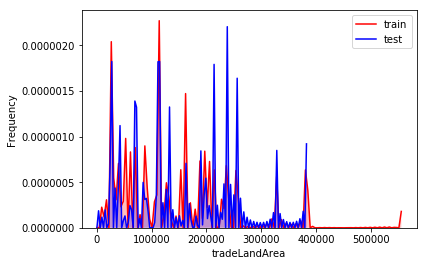

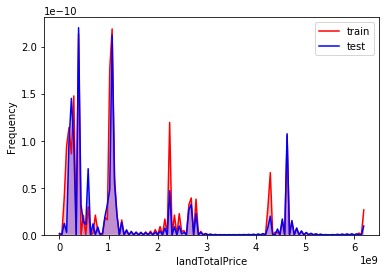

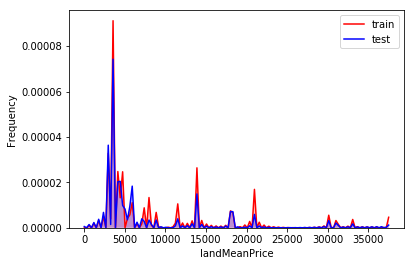

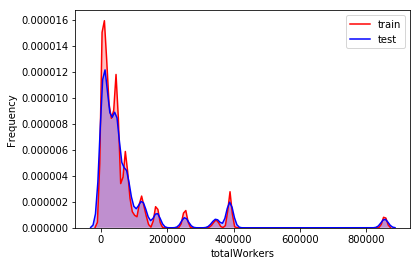

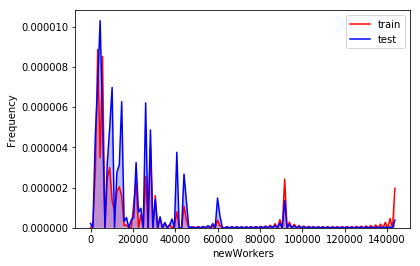

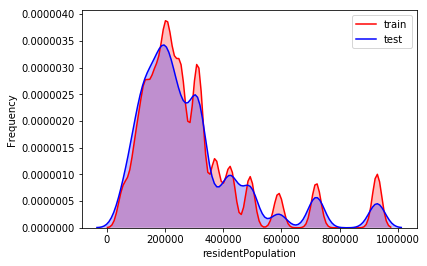

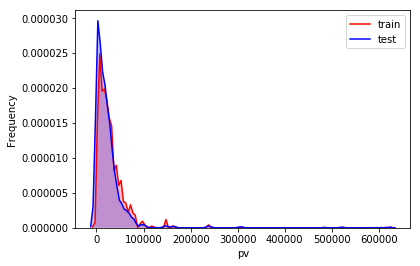

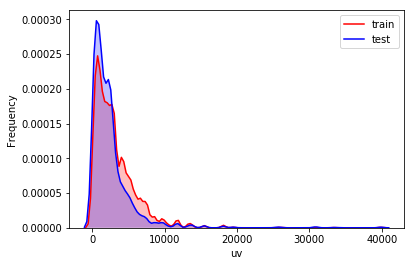

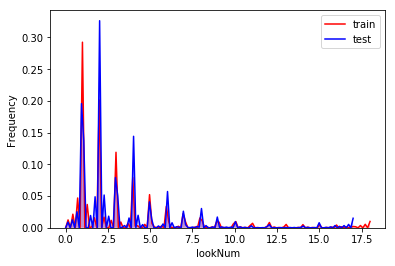

In [85]:
#查看连续变量在训练集和测试集的分布
features = [i for i in f2 if i not in ['ID','tradeMoney']]
for column in features:
    g = sns.kdeplot(train[column], color="Red", shade = True)
    g = sns.kdeplot(test[column], ax =g, color="Blue", shade= True)
    g.set_xlabel(column)
    g.set_ylabel("Frequency")
    g = g.legend(["train","test"])
    plt.show()

In [18]:
# 根据训练集和测试集的分布情况，对训练集进行以下处理：
# area(10,180)
# tradeMoney(500,40000)
# totalFloor(,60)
# saleSecHouseNum(,15)
# remainNewNum(,3000)
# supplyLandArea(,400000)
# lookNum(,18)
# totalFloor(,60)


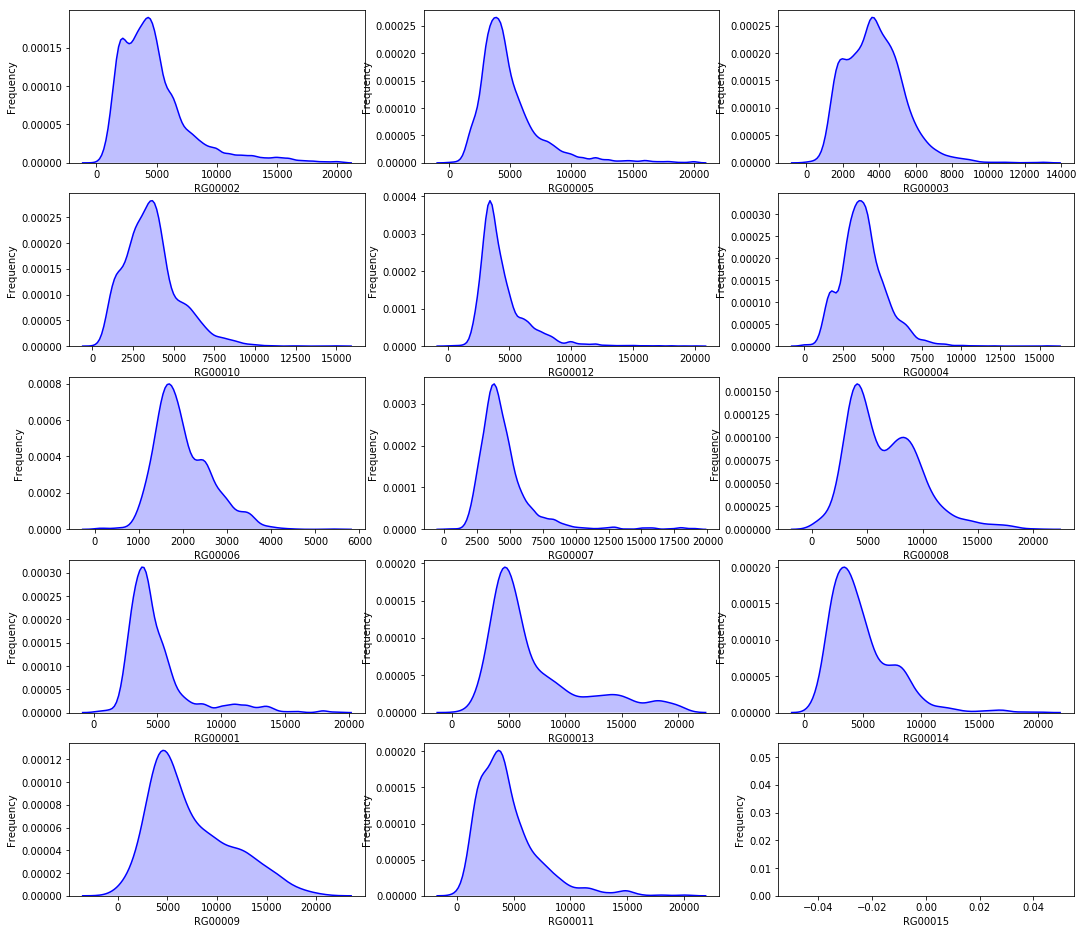

In [91]:
#每个region 对应的交易金额分布
fig, axs = plt.subplots(ncols=2, nrows=0, figsize=(18,50))
for i,val in enumerate(train.region.value_counts().index,1):
    plt.subplot(len(train.region.value_counts().index), 3, i)
    g= sns.kdeplot(train[train['region']==val]['tradeMoney'].values,  color="Blue", shade= True)
    g.set_xlabel(val)
    g.set_ylabel("Frequency")
#     plt.show()

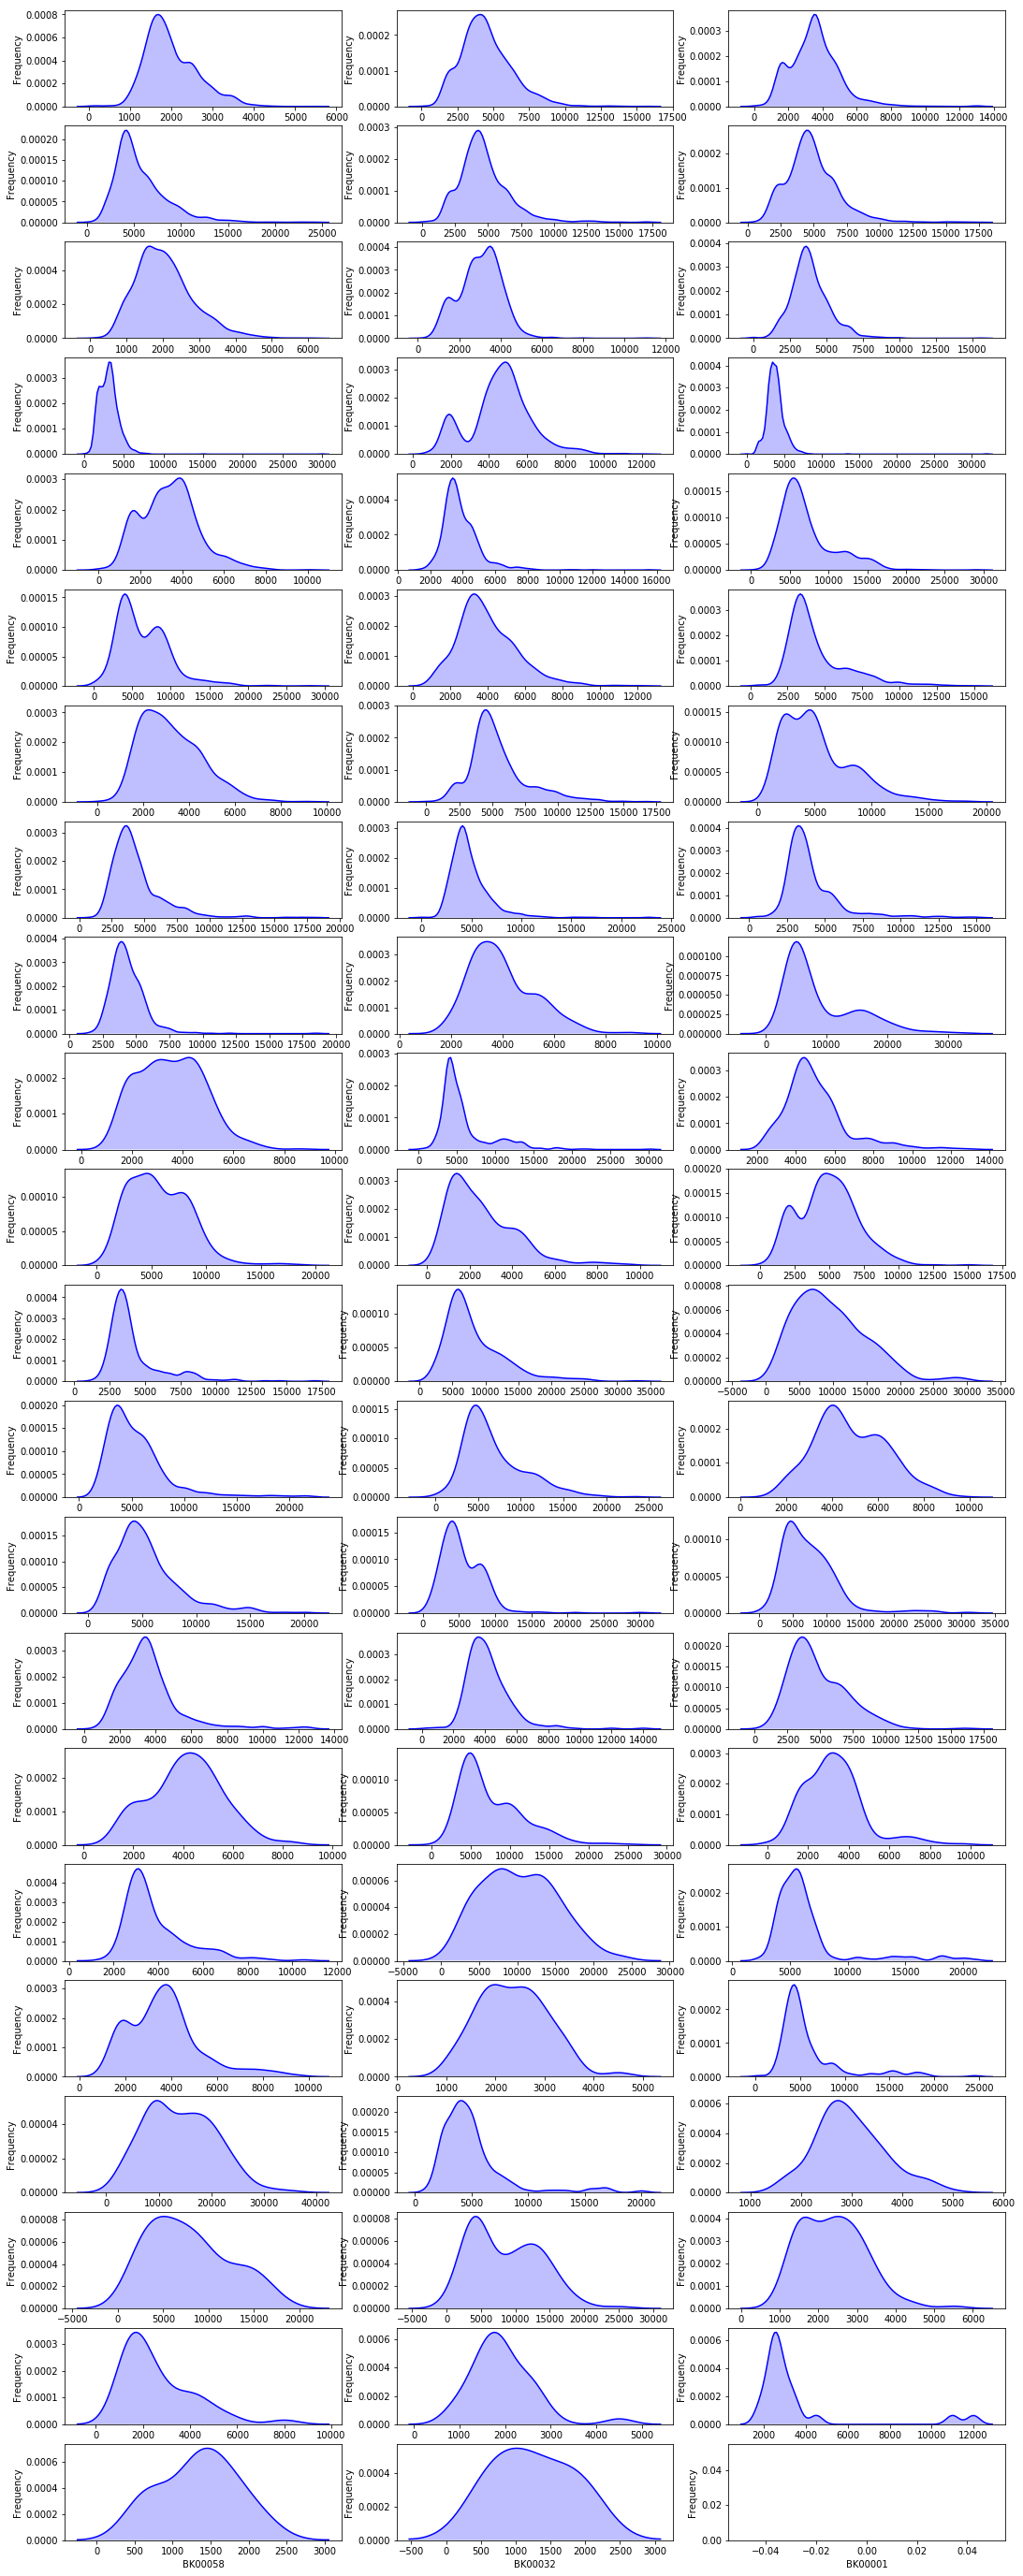

In [29]:
#每个plate对应的交易金额的分布
fig, axs = plt.subplots(ncols=2, nrows=0, figsize=(18,150))
for i,val in enumerate(train.plate.value_counts().index,1):
    plt.subplot(len(train.plate.value_counts().index), 3, i)
    g= sns.kdeplot(train[train['plate']==val]['tradeMoney'].values,  color="Blue", shade= True)
    g.set_xlabel(val)
    g.set_ylabel("Frequency")
#     plt.show()

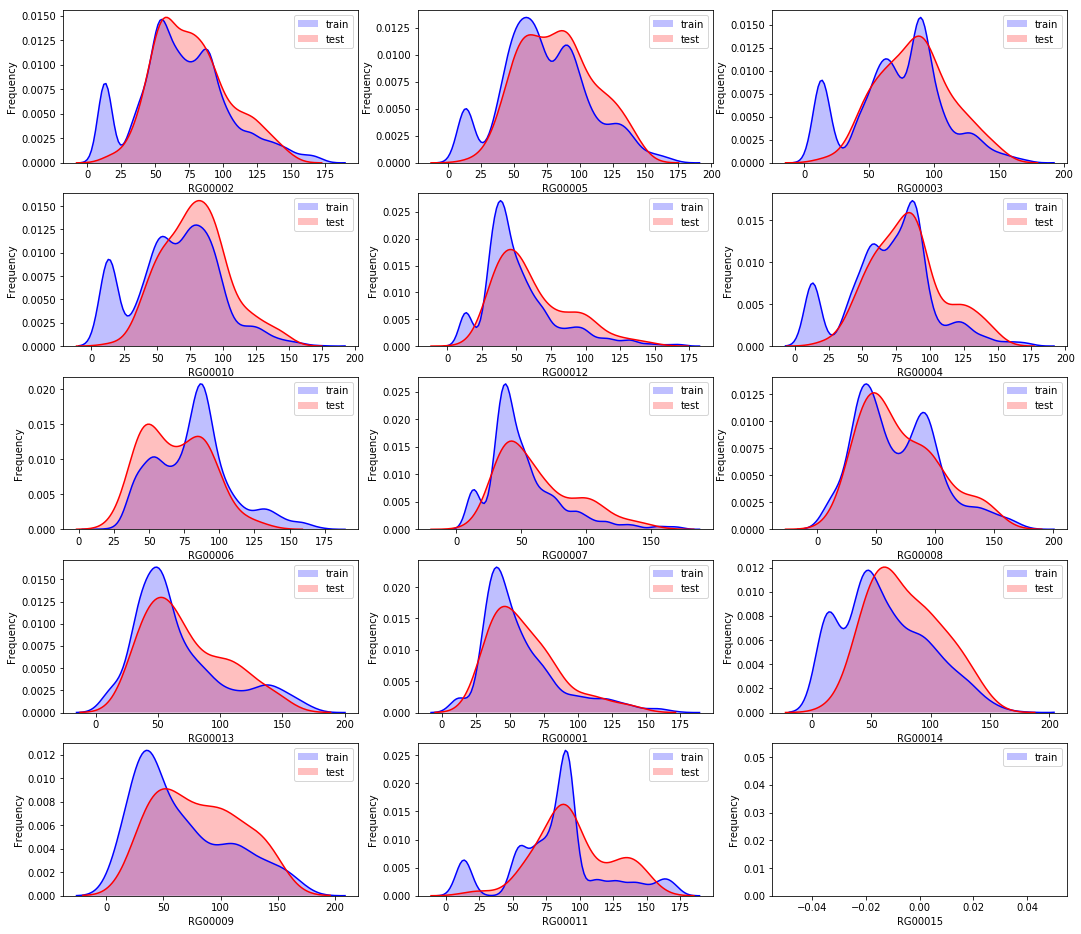

In [24]:
#查看每个region对应的area在训练集和测试集上的分布
fig, axs = plt.subplots(ncols=2, nrows=0, figsize=(18,50))
for i,val in enumerate(train.region.value_counts().index,1):
    plt.subplot(len(train.region.value_counts().index), 3, i)
    g= sns.kdeplot(train[train['region']==val]['area'].values,  color="Blue", shade= True)
    g= sns.kdeplot(test[test['region']==val]['area'].values,  color="Red", shade= True)
    g.set_xlabel(val)
    g.set_ylabel("Frequency")
    g = g.legend(["train","test"])

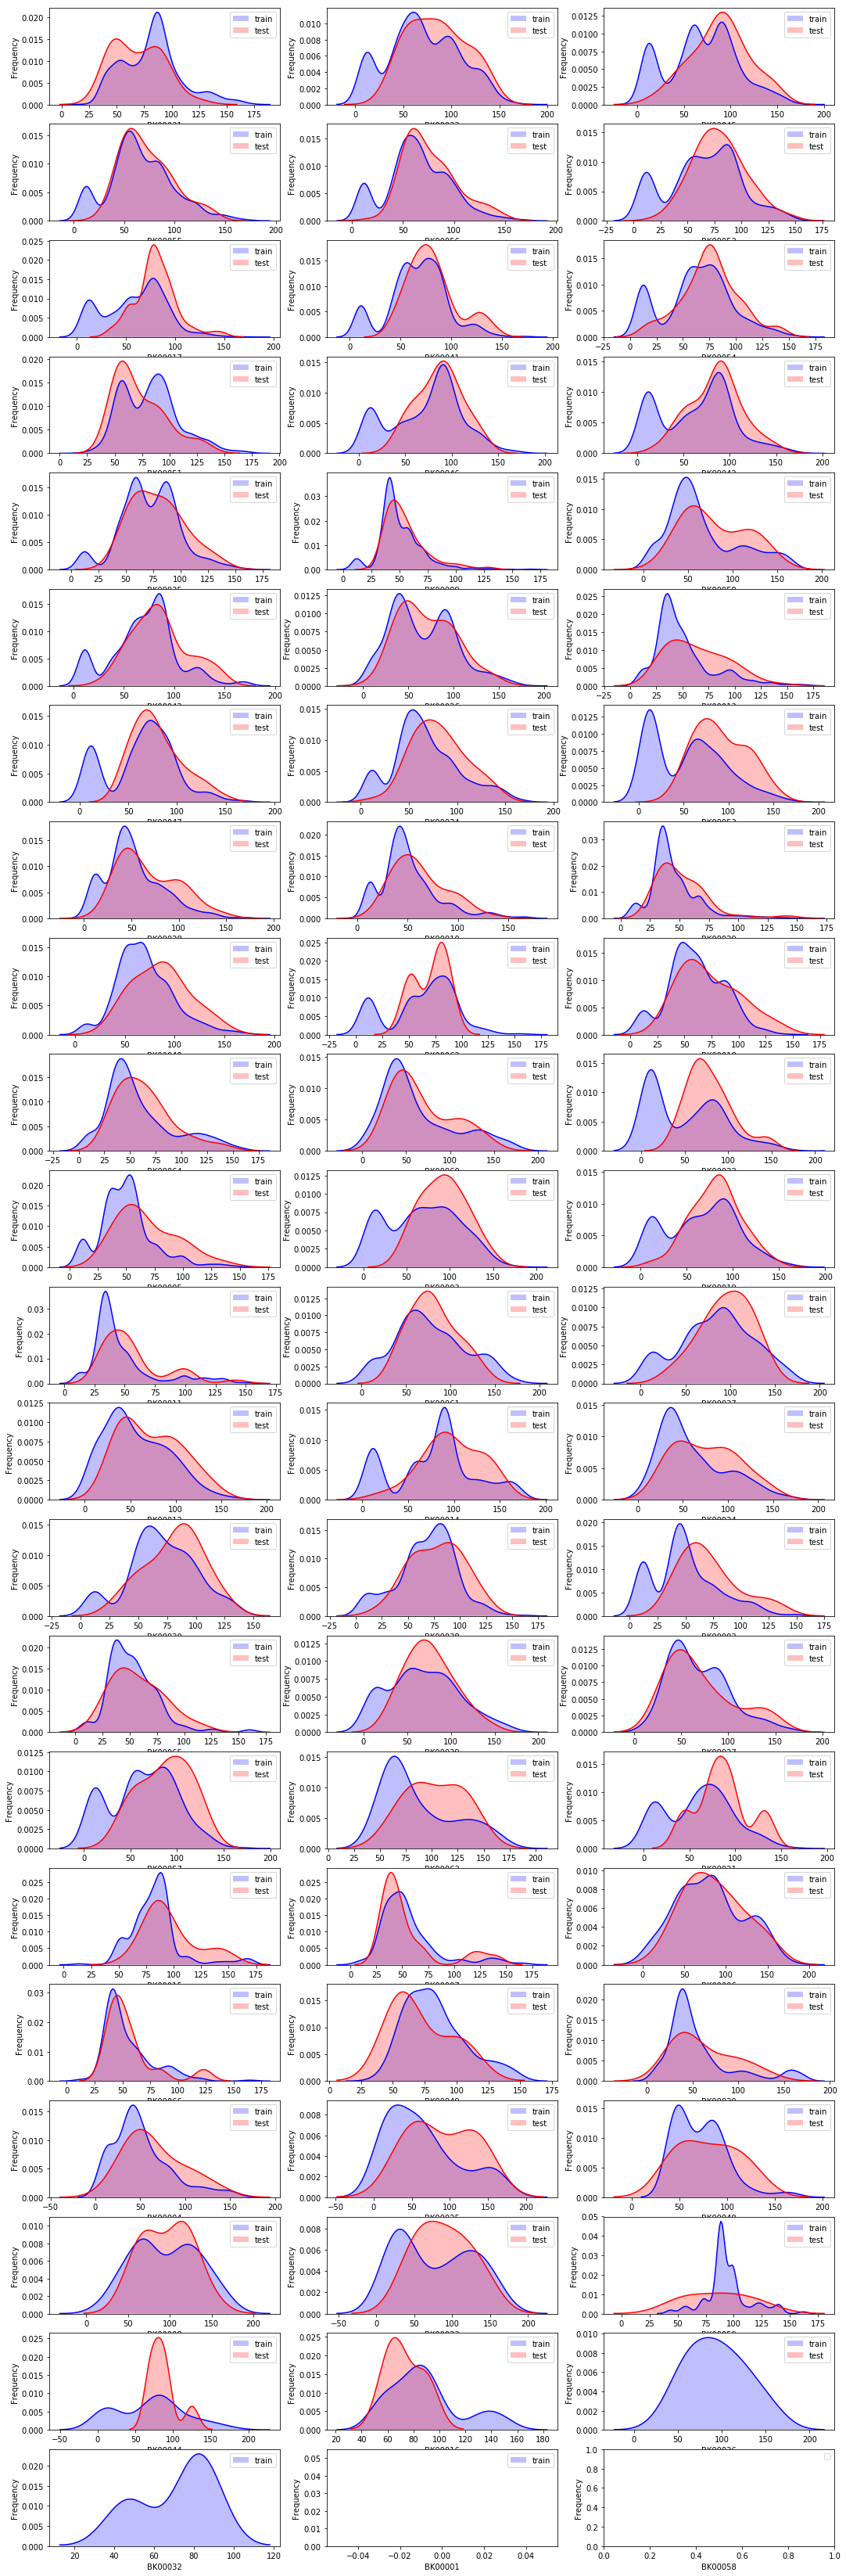

In [43]:
#查看每个plate对应的area在训练集和测试集上的分布
fig, axs = plt.subplots(ncols=2, nrows=0, figsize=(18,180))
for i,val in enumerate(train.plate.value_counts().index,1):
    plt.subplot(len(train.plate.value_counts().index), 3, i)

    g= sns.kdeplot(train[train['plate']==val]['area'].values,  color="Blue", shade= True)
    g= sns.kdeplot(test[test['plate']==val]['area'].values,  color="Red", shade= True)
    g.set_xlabel(val)
    g.set_ylabel("Frequency")
    g = g.legend(["train","test"])

In [93]:
# 1、缺失值
# bulidYear 用meidan中位数（2002）填充（比mode众数（1994）效果好一些）
# pv、uv使用均值填充

# 2、异常值处理
# 从train和测试分布可知对以下特征的取值范围做如下处理：
# area(10,180)
# tradeMoney(500,40000)
# totalFloor(,60)
# saleSecHouseNum(,15)
# remainNewNum(,3000)
# supplyLandArea(,400000)
# lookNum(,18)
# totalFloor(,60)

# 3、其他的不会了，也没从小区对应的交易金额分布看出啥
# 最后的结果，对比0.913为0.9509491695216808，相当于达到0.8682165917732947


In [69]:
#baseline
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

In [70]:
def parseData(df):
    """
    预处理数据
    """
    df['rentType'][df['rentType']=='--'] = '未知方式'
    # 转换object类型数据
    columns = ['rentType', 'houseFloor', 'houseToward', 'houseDecoration', 'communityName', 'region', 'plate']
    for col in columns:
        df[col] = df[col].astype('category')
        
    # 将buildYear列转换为整型数据
    tmp = df['buildYear'].copy()
    tmp2 = tmp[tmp!='暂无信息'].astype('int')
    print(len(tmp[tmp!='暂无信息']))
    print(tmp2.median())
#     tmp[tmp=='暂无信息'] = tmp2.mode().iloc[0]
    tmp[tmp=='暂无信息'] = tmp2.median()
    df['buildYear'] = tmp
    df['buildYear'] = df['buildYear'].astype('int')
    
    # 处理pv和uv的空值
    df['pv'].fillna(df['pv'].mean(),inplace=True)
    df['uv'].fillna(df['uv'].mean(),inplace=True)
    df['pv'] = df['pv'].astype('int')
    df['uv'] = df['uv'].astype('int')
    
    # 去掉部分特征
    df.drop('communityName',axis=1, inplace=True)
    df.drop('city',axis=1,inplace=True)
    
    return df

In [71]:
def washData(df_train, df_test):
    """
    清洗数据
    """
    df_train = df_train[(df_train['area']<=175)&(df_train['area']>6)]
    df_train = df_train[(df_train['tradeMoney']<=20000)&(df_train['tradeMoney']>600)]
    df_train = df_train[df_train['totalFloor']<=60]
    df_train = df_train[df_train['saleSecHouseNum']<=15]
    df_train = df_train[df_train['remainNewNum']<=3000]
    
    df_train = df_train[df_train['supplyLandArea']<=400000]
    df_train = df_train[df_train['lookNum']<=18]
    df_train = df_train[df_train['totalFloor']<=60]
    
    df_train.drop('ID', axis=1, inplace=True)
    df_test.drop('ID', axis=1,inplace=True)
    
    return df_train, df_test

In [72]:
def feature(df):
    """
    特征
    """
    # 将houseType转化为‘房间数’，‘厅数’，‘卫生间数’
    def parseRoom(info, index):
        res = int(info[index*2])
        return res
    df.insert(3,'室',None)
    df.insert(4, '厅', None)
    df.insert(5, '卫', None)
    df['室'] = df['houseType'].apply(parseRoom, index=0)
    df['厅'] = df['houseType'].apply(parseRoom, index=1)
    df['卫'] = df['houseType'].apply(parseRoom, index=2)
    
    df['交易月份'] = df['tradeTime'].apply(lambda x: int(x.split('/')[1]))
#     df['pv/uv'] = df['pv'] / df['uv']
#     df['房间总数'] = df['室'] + df['厅'] + df['卫']
    
    df.drop('houseType', axis=1, inplace=True)
    df.drop('tradeTime', axis=1, inplace=True)
    
    categorical_feats = ['rentType', 'houseFloor', 'houseToward', 'houseDecoration', 'region', 'plate']
    return df, categorical_feats

In [73]:
def getData(feature):
    """
    获取数据
    """
    train = pd.read_csv('data/train_data.csv')
    test = pd.read_csv('data/test_a.csv')
    
    train = parseData(train)
    test = parseData(test)
    train, test = washData(train, test)
    
    train, col = feature(train)
    test, col = feature(test)
    
    target = train.pop('tradeMoney')
    features = train.columns
    categorical_feats = col
    
    return train, test, target, features, categorical_feats

In [74]:
train, test, target, features, categorical_feats = getData(feature)

38632
2002.0
2341
1999.0


In [75]:
len(train)

39694

In [76]:
features

Index(['area', 'rentType', '室', '厅', '卫', 'houseFloor', 'totalFloor',
       'houseToward', 'houseDecoration', 'region', 'plate', 'buildYear',
       'saleSecHouseNum', 'subwayStationNum', 'busStationNum',
       'interSchoolNum', 'schoolNum', 'privateSchoolNum', 'hospitalNum',
       'drugStoreNum', 'gymNum', 'bankNum', 'shopNum', 'parkNum', 'mallNum',
       'superMarketNum', 'totalTradeMoney', 'totalTradeArea', 'tradeMeanPrice',
       'tradeSecNum', 'totalNewTradeMoney', 'totalNewTradeArea',
       'tradeNewMeanPrice', 'tradeNewNum', 'remainNewNum', 'supplyNewNum',
       'supplyLandNum', 'supplyLandArea', 'tradeLandNum', 'tradeLandArea',
       'landTotalPrice', 'landMeanPrice', 'totalWorkers', 'newWorkers',
       'residentPopulation', 'pv', 'uv', 'lookNum', '交易月份'],
      dtype='object')

In [77]:
categorical_feats

['rentType', 'houseFloor', 'houseToward', 'houseDecoration', 'region', 'plate']

In [78]:
params = {
    'num_leaves': 100,
    'min_data_in_leaf': 20,
    'min_child_samples':20,
    'objective': 'regression',
    'learning_rate': 0.01,
    "boosting": "gbdt",
    "feature_fraction": 0.8,
    "bagging_freq": 1,
    "bagging_fraction": 0.85,
    "bagging_seed": 23,
    "metric": 'rmse',
    "lambda_l1": 0.2,
    "nthread": 4,
}

In [79]:
len(train)

39694

In [80]:
folds = KFold(n_splits=5, shuffle=True, random_state=2333)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx], label=target.iloc[trn_idx], categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx], label=target.iloc[val_idx], categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 200)
    
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions_lgb += clf.predict(test, num_iteration=clf.best_iteration) / folds.n_splits
    
print("CV Score: {:<8.5f}".format(r2_score(target, oof_lgb)))

fold 0
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 723.189	valid_1's rmse: 891.88
[1000]	training's rmse: 616.872	valid_1's rmse: 872.81
[1500]	training's rmse: 554.769	valid_1's rmse: 869.115
[2000]	training's rmse: 509.575	valid_1's rmse: 867.826
Early stopping, best iteration is:
[2216]	training's rmse: 493.167	valid_1's rmse: 867.651
fold 1
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 723.868	valid_1's rmse: 895.198
[1000]	training's rmse: 617.297	valid_1's rmse: 870.6
[1500]	training's rmse: 554.862	valid_1's rmse: 864.146
[2000]	training's rmse: 509.172	valid_1's rmse: 862.616
[2500]	training's rmse: 473.674	valid_1's rmse: 862.138
Early stopping, best iteration is:
[2682]	training's rmse: 462.344	valid_1's rmse: 861.735
fold 2
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 729.071	valid_1's rmse: 872.847
[1000]	training's rmse: 622.088	valid_1's rmse: 844.319

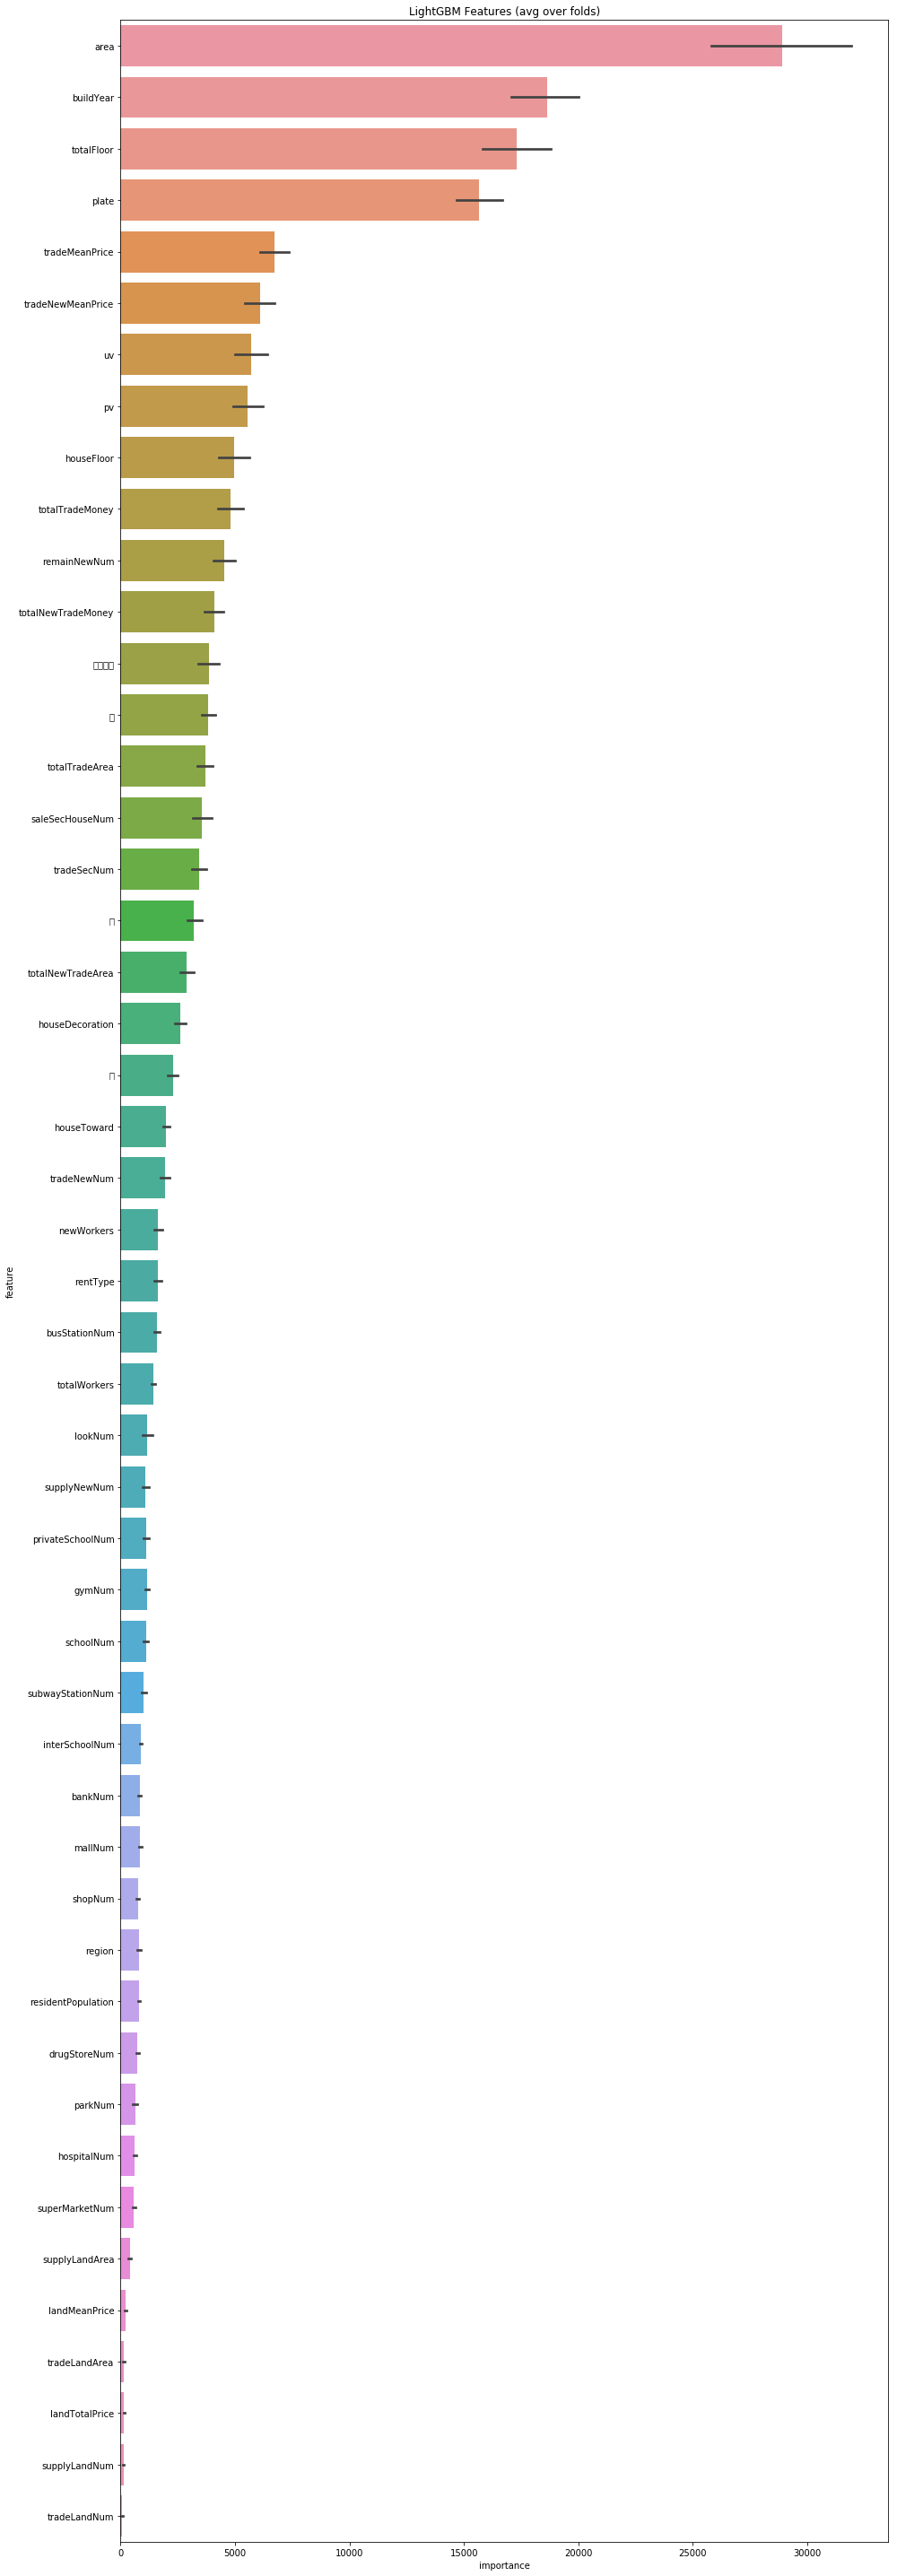

In [13]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,40))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [81]:
from sklearn.metrics import r2_score
def online_score(pred):
    print("预测结果最大值：{},预测结果最小值：{}".format(pred.max(),pred.min()))
    # a榜测分
    conmbine1 = pd.read_csv("./best_result/sub_a_913.csv",engine = "python",header=None)
    score1 = r2_score(list(map(lambda x:int(x),pred)), conmbine1.values)
    print("对比913分数:{}".format(score1))

In [82]:
online_score(predictions_lgb)

预测结果最大值：18068.803639262303,预测结果最小值：1125.6454778829875
对比913分数:0.9509491695216808


In [83]:
0.9509491695216808*0.913

0.8682165917732947